# Melanoma Detection

This is an attempt to differentiate between three types of skin lesions, melanoma, nevi and seborrheic keratosesone. Melanoma is cancerous; the other three are benign.

The data and objective are from the [ISIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), as presented in the [udacity/dermatologist-ai](https://github.com/udacity/dermatologist-ai) repository. I used same [train](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip), [vaidation](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip) and [test](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip) data hosted by Udacity.

I originally worked on the problem in the [Udacity Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101) program. I wanted to revisit the problem using the [fastai](https://github.com/fastai/fastai) library.


In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *
from fastai.metrics import error_rate
from functools import partial

In [9]:
np.random.seed(303)

## Load and view data

In [10]:
datapath = Path('../data').resolve() # absolute path to data
!ls $datapath

data  models  original_image_data.zip  test  train  valid


In [6]:
# # speed processing by reducing image size to max dimension of 300px
# # NB this overwrites original images!
# for dtype in ['test', 'train', 'valid']:
#     for dclass in ['melanoma', 'nevus', 'seborrheic_keratosis']:
#         path = datapath / dtype / dclass
#         print(dtype, dclass)
#         verify_images(path, max_size=300)

In [26]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [32]:
get_bunch = partial(ImageDataBunch.from_folder, datapath, bs=64, ds_tfms=tfms)

In [40]:
data = get_bunch(size=150).normalize(imagenet_stats)

In [7]:
# data = ImageDataBunch.from_folder(datapath, ds_tfms=tfms, bs=bs, size=224, num_workers=4)

In [38]:
print(data.classes)

['melanoma', 'nevus', 'seborrheic_keratosis']


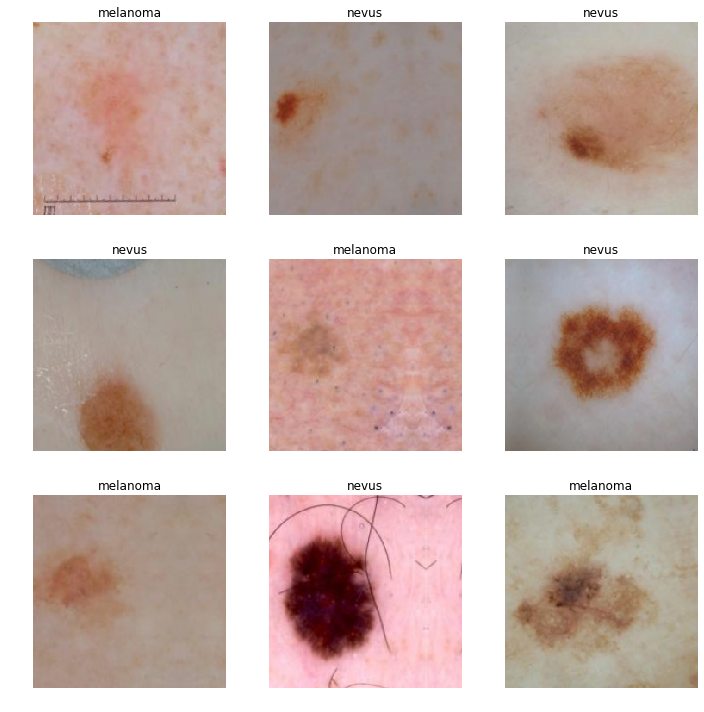

In [39]:
data.show_batch(rows=3, figsize=(10, 10))

## Resnet 34

### Train: Phase 1

In [10]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,1.319932,0.915284,0.386667
2,1.063404,0.738747,0.313333
3,0.926735,0.762484,0.333333
4,0.808694,0.772194,0.306667
5,0.725403,0.723001,0.293333
6,0.678507,0.724062,0.320000
7,0.642068,0.706407,0.320000
8,0.620511,0.703558,0.300000


In [12]:
learn.save('res34-frozen')

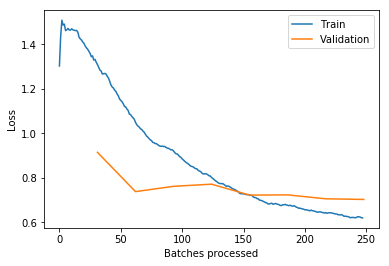

In [13]:
learn.recorder.plot_losses()

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

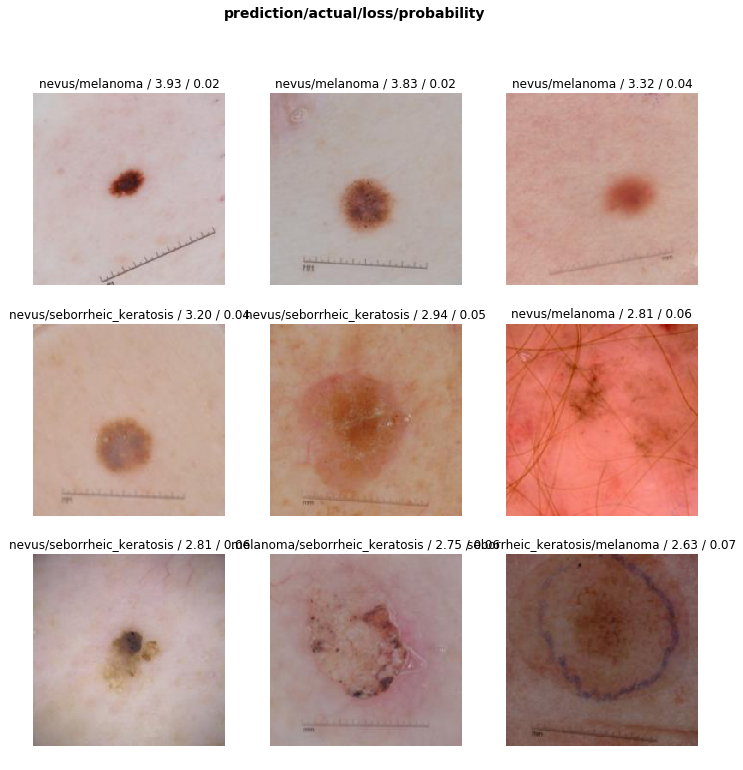

In [15]:
interp.plot_top_losses(9, figsize=(12, 12))

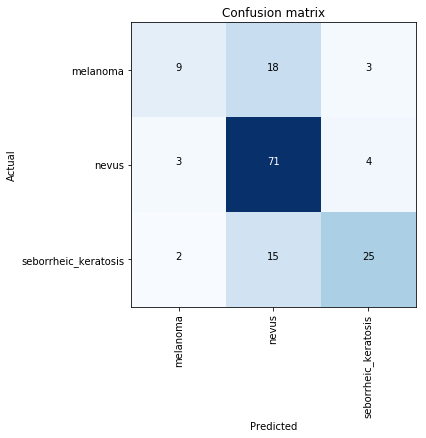

In [16]:
interp.plot_confusion_matrix(figsize=(6, 6))

### Train: Phase 2

In [17]:
_ = learn.load('res34-frozen')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


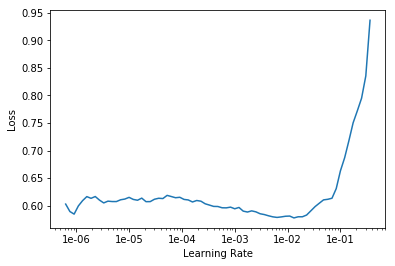

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,error_rate
1,0.638305,0.788120,0.326667
2,0.627848,0.649343,0.253333
3,0.573186,0.571827,0.200000
4,0.510249,0.522986,0.206667


In [20]:
learn.save('res34-unfrozen')

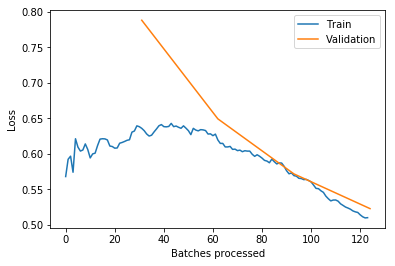

In [21]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)